
### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2020 Semester 1

## Assignment 1: Naive Bayes Classifiers

###### Submission deadline: 7 pm, Monday 20 Apr 2020

**Student Name(s):**    `Alec Yu, Michael Jaworski`

**Student ID(s):**     `993433, `


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [3]:
import numpy as np
from collections import defaultdict
import re
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [4]:
# Lists for all the datafiles and their types
nominal_files = ["breast-cancer-wisconsin", "mushroom", "lymphography", "train"]
numeric_files = ["wdbc", "wine"]
ordinal_files = ["car", "nursery", "somerville"]
mixed_files = ["adult", "bank", "university"]

# use trainingtest" for naive bayes example in slides
file = "wine"
filename = "datasets/%s.data" % file
headerfile = "datasets/%s.h" % file

if(file in nominal_files):
    datatype = "nominal"
elif (file in ordinal_files):
    datatype = "ordinal"
elif (file in numeric_files):
    datatype = "numeric"
elif (file in mixed_files):
    datatype = "mixed"

In [5]:
# Read the datafile in with a separate header file for attributes
dataframe = pd.read_csv(filename, header=None)
header = open(headerfile, "r")
attributes = header.readline().split(",")
dataframe.columns = attributes

In [6]:
# This function should prepare the data by reading it from a file and converting it into a useful format for training and testing

def preprocess(dataframe, datatype): 
    # Create a copy of the original dataframe. Remove rows with ? in this copy
    df = dataframe

    # If it's mushroom data, drop the stalk-root column as it has too many missing values. Don't use this attribute
    if(filename == "datasets/mushroom.data"):
        df = df.drop(columns = ['stalk-root'])

    # Otherwise just remove the entries with a ? for now
    for index in df.index:
        if('?' in df.loc[index].values):
            df = df.drop(index)
    
    # Leave nominal, ordinal and numeric data as it is.
    
    # If the data is mixed, we need to discretise the data, as each mixed data set is a classification task using NB
    if(datatype == 'mixed'):
        df = discretiseNumeric(df)
        
    # Also, move CLASS column to the end
    temp = df.pop('CLASS')
    df['CLASS'] = temp
    
    return df

############################################################################################################################
# Choice is to use equal-frequency discretisation. More detailed than equal-width discretisation. Here, computing an 
# "Optimal" number of clusters for k means clustering for every numeric column would not be feasible. If choosing an 
# Arbitrary K clusters for every single discretisation, then it isn't as effective
# For equal-frequency, sometimes the attributes won't have many values, so migth be less than 5 bins. Thats okay though

def discretiseNumeric(df):
    for column in df.columns:
        if(df.dtypes[column] == "int64" or df.dtypes[column] == "float64"):
            values = df[column].values
            values.sort()
            
            # Check if the values are already "Discretised" (<, say, 8 unique values. This occurs for ratings 0-5 etc..).
            # If so, then no need to discretise the attribute
            uniqueValues = set(values)
            if(len(uniqueValues) <= 8):
                continue
            
            # Choose 5 equal-frequency bins, based on sorted values
            # Should every attribute be split into 5 bins?
            
            bin1 = values[(int)(len(values)/5)]
            bin2 = values[2 * (int)(len(values)/5)]
            bin3 = values[3 * (int)(len(values)/5)]
            bin4 = values[4 * (int)(len(values)/5)]
            bin5 = values[5 * (int)(len(values)/5)]
            
            # Now assign every value to be in a bin number
            for i in range(len(df[column].values)):
                if(df[column].values[i] <= bin1):
                    df[column].values[i] = 1
                elif(df[column].values[i] <= bin2):
                    df[column].values[i] = 2
                elif(df[column].values[i] <= bin3):
                    df[column].values[i] = 3
                elif(df[column].values[i] <= bin4):
                    df[column].values[i] = 4
                elif(df[column].values[i] <= bin5):
                    df[column].values[i] = 5
                
    return df

############################################################################################################################

df2 = dataframe.copy()
df2 = preprocess(df2, datatype)
df2

C:\Users\alecy\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  del sys.path[0]


,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,CLASS
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.640000,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.380000,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.680000,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.800000,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.320000,1.04,2.93,735,1
5,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.750000,1.05,2.85,1450,1
6,14.39,1.87,2.45,14.6,96,2.50,2.52,0.30,1.98,5.250000,1.02,3.58,1290,1
7,14.06,2.15,2.61,17.6,121,2.60,2.51,0.31,1.25,5.050000,1.06,3.58,1295,1
8,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.200000,1.08,2.85,1045,1
9,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.220000,1.01,3.55,1045,1


In [7]:
# This function should calculate prior probabilities and likelihoods from the training data and using
# them to build a naive Bayes model

def train(dataframe, datatype):
    
    if(datatype in ["nominal", "ordinal", "mixed"]):
        modeltype = 'NB'
    elif(datatype in ["numeric"]):
        modeltype = 'GNB'
    
    if(modeltype == 'NB'):
        trainNB(dataframe)
    elif(modeltype == 'GNB'):
        trainGNB(dataframe)
    return

In [8]:
def trainNB(dataframe): 
    
    # Count all the frequencies of each class label
    priors = dict()
    for index in dataframe.index:
        item = dataframe.loc[index]['CLASS']
        if(item in priors):
            priors[item] += 1
        else:
            priors[item] = 1
            
    # Sum the total to convert each class label to a probability
    total = sum(priors.values())
    
    # Each unique class label now has a prior probability as a value
    for key, value in priors.items():
        priors[key] = value/total
        
    # Once we have the priors, we need all the conditional probabilities
    # Use a list of dictionaries of dictionaries
    
    # We need these to iterate through them and count instances
    attributes = list(dataframe.columns)[:-1]
    uniqueClassLabels = list(set(dataframe['CLASS'].values))
    
    attributeDicts = list()
    
    # For each attribute create a dictionary with class labels as keys.
    # Values are another dictionary with unique values in that attribute,
    # Then count frequencies of uniqueattvalues given class label
    for attribute in attributes:
        dict1 = dict()
        uniqueAttributeValues = list(set(dataframe[attribute].values))
        for classLabel in uniqueClassLabels:
            dict2 = dict()
            dict1[classLabel] = dict2
            for attributeValue in uniqueAttributeValues:
                dict2[attributeValue] = dataframe[(dataframe[attribute] == attributeValue) & (dataframe['CLASS'] == classLabel)].shape[0]
        attributeDicts.append(dict1)
    
    # Once we have the frequencies, can just convert each to be probabilities
    for attributedict in attributeDicts:
        for classLabel, classLabelDict in attributedict.items():
            totalFreq = sum(classLabelDict.values())
            for attributeLevel, freq in classLabelDict.items():
                classLabelDict[attributeLevel] = freq / totalFreq

    # EACH DICTIONARY IN attributeDicts IS IN ORDER OF THE HEADER COLUMNS
    i = 0;
    for dictionary in attributeDicts:
        print(attributes[i])
        i += 1
        for classLabel, dict2 in dictionary.items():
            print(classLabel)
            print(dict2)
            print(sum(dict2.values()))
    
    return attributeDicts, priors

In [9]:
def trainGNB(dataframe):
        
    # Count all the frequencies of each class label
    priors = dict()
    for index in dataframe.index:
        item = dataframe.loc[index]['CLASS']
        if(item in priors):
            priors[item] += 1
        else:
            priors[item] = 1
            
    # Sum the total to convert each class label to a probability
    total = sum(priors.values())
    
    # Each unique class label now has a prior probability as a value
    for key, value in priors.items():
        priors[key] = value/total
        
    # Just need to store mean, stdev for every attribute for each unique class label    
    meanDict = df2.groupby('CLASS').mean().to_dict()
    stdDict = df2.groupby('CLASS').std().to_dict()
    
    print(meanDict['feat11'])
    print(stdDict['feat11'])

    return meanDict, stdDict, priors

# Calculates probability density given a gaussian dist with mean and std 
def calculateDensity(mean, std, x):
    exponent = math.exp((-1.0/2) * (((x - mean) / std) ** 2))
    return (1 / (math.sqrt(2 * math.pi) * std)) * exponent

In [10]:
train(df2, datatype)

{1: 1.0620338983050848, 2: 1.0562816901408452, 3: 0.6827083333333334}
{1: 0.11648264131468114, 2: 0.20293680811654433, 3: 0.1144410948234819}


In [11]:
# This function should predict classes for new items in a test dataset (for the purposes of this assignment, you
# can re-use the training data as a test set

# Multiplying probs, need to take logs of probabilities
# Smoothe training probabilities
# Change format of the probabilities, and ways of accessing them
def predict():
    return

The accuracy of the predictions is: 0.20033

Confusion Matrix of Truths vs Predicted frequencies

Predicted    0    1    2    3    4   All
Truths                                  
0          120  141  109  119  118   607
1          149  111  136  113  113   622
2          104  115  116  132  122   589
3          113  127  113  119  116   588
4          111  119  113  116  135   594
All        597  613  587  599  604  3000



Confusion Matrix of Correctly Labeled Classes %'s

Predicted         0         1         2         3         4
Truths                                                     
0          0.197694  0.226688  0.185059  0.202381  0.198653
1          0.245470  0.178457  0.230900  0.192177  0.190236
2          0.171334  0.184887  0.196944  0.224490  0.205387
3          0.186161  0.204180  0.191851  0.202381  0.195286
4          0.182867  0.191318  0.191851  0.197279  0.227273





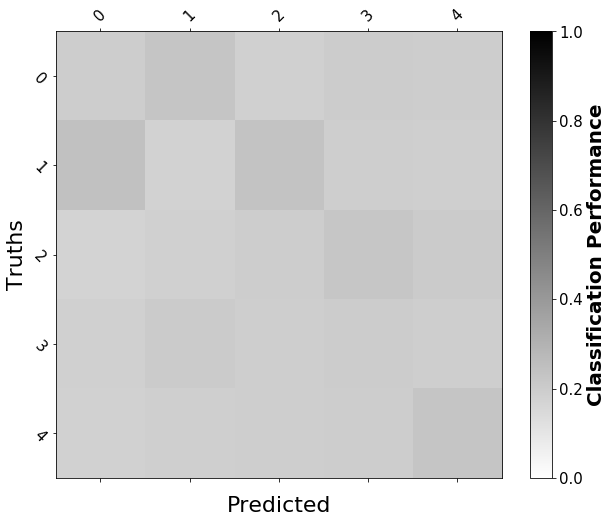

In [127]:
# This function should evaliate the prediction performance by comparing your model’s class outputs to ground
# truth labels

# CODE TO RUN M-CROSS VALIDATION
m = 5;
width = int(dataframe.shape[0] / m);
evaluations = []
for i in range(0,m):
    testSet = dataframe.index[i*width:(i+1)*width]
    trainSet = dataframe.drop(dataframe.index[i*width:(i+1)*width])
    # Call predict using thse two dataframes

    
    
# Currently uses Crude total accuracy, confusion matrix of truth vs classified %'s as evaluation metrics
# Calculates the prediction accuracy and outputs a confusion matrix of truths vs predictions

def evaluate(truthlist, predictions):
    # First calculate a crude accuracy score
    correct = 0;
    wrong = 0;
    for i in range(0,len(truthlist)):
        if(truthlist[i] == predictions[i]):
            correct += 1
        else:
            wrong += 1;
    print("The accuracy of the predictions is: {:.5f}\n".format(correct/(correct + wrong)))
        
    # Now construct a confusion matrix of each attribute
    truthSeries = pd.Series(truthlist, name = "Truths")
    predictionSeries = pd.Series(predictions, name = "Predictions")
    confusionDf = pd.crosstab(truthSeries, predictionSeries, rownames=["Truths"], colnames=["Predicted"], margins=True)
    print("Confusion Matrix of Truths vs Predicted frequencies\n")
    print(confusionDf)
    print("\n\n")
    
    # Now normalise the confusion matrix so its a percentage of classification performance
    confusionDf = pd.crosstab(truthSeries, predictionSeries, rownames=["Truths"], colnames=["Predicted"], margins=False)
    confusionDfNormalised = confusionDf / confusionDf.sum(axis=1)
    print("Confusion Matrix of Correctly Labeled Classes %'s\n")
    print(confusionDfNormalised)
    print("\n\n")
    
    # Now print out the color map of the classification performaces
    plot_color_map(confusionDfNormalised)
    
    return

# Plots the confusion matrix

def plot_color_map(confusionDf):
    title = "Confusion Matrix"
    cmap = plt.cm.gray_r
    plt.figure(figsize=(10,8))
    plt.matshow(confusionDf, cmap = cmap, fignum=1)
    
    # Set the scale (0,1) and fontsize for the color bar
    plt.clim(0, 1)
    cbar = plt.colorbar()
    cbar.set_label(label="Classification Performance", weight="bold", fontsize=20)
    cbar.ax.tick_params(labelsize=15)
    
    # Axis information
    tick_marks = np.arange(len(confusionDf.columns))
    plt.xticks(tick_marks, confusionDf.columns, rotation = 45, fontsize=15)
    plt.yticks(tick_marks, confusionDf.index, rotation = -45, fontsize=15)
    plt.ylabel(confusionDf.index.name, fontsize=22)
    plt.xlabel(confusionDf.columns.name, labelpad = 18, fontsize=22)
    
    return

# Finds the most common class label and returns it. Use this to predict all instances as a baseline
def zeroR(df):
    classLabel = df['CLASS'].value_counts().idxmax();
    return classLabel

import random

# Test sets. Currently uniformly distributed classes in range (0,5)

testTruth = [random.randrange(0,5,1) for i in range(3000)]
testPred = [random.randrange(0,5,1) for i in range(3000)]

evaluate(testTruth, testPred)


## Questions 


If you are in a group of 1, you will respond to question (1), and **one** other of your choosing (two responses in total).

If you are in a group of 2, you will respond to question (1) and question (2), and **two** others of your choosing (four responses in total). 

A response to a question should take about 100–250 words, and make reference to the data wherever possible.

#### NOTE: you may develope codes or functions in respond to the question, but your formal answer should be added to a separate file.

### Q1
Try discretising the numeric attributes in these datasets and treating them as discrete variables in the na¨ıve Bayes classifier. You can use a discretisation method of your choice and group the numeric values into any number of levels (but around 3 to 5 levels would probably be a good starting point). Does discretizing the variables improve classification performance, compared to the Gaussian na¨ıve Bayes approach? Why or why not?

### Q2
Implement a baseline model (e.g., random or 0R) and compare the performance of the na¨ıve Bayes classifier to this baseline on multiple datasets. Discuss why the baseline performance varies across datasets, and to what extent the na¨ıve Bayes classifier improves on the baseline performance.

### Q3
Since it’s difficult to model the probabilities of ordinal data, ordinal attributes are often treated as either nominal variables or numeric variables. Compare these strategies on the ordinal datasets provided. Deterimine which approach gives higher classification accuracy and discuss why.

### Q4
Evaluating the model on the same data that we use to train the model is considered to be a major mistake in Machine Learning. Implement a hold–out or cross–validation evaluation strategy (you should implement this yourself and do not simply call existing implementations from `scikit-learn`). How does your estimate of effectiveness change, compared to testing on the training data? Explain why. (The result might surprise you!)

### Q5
Implement one of the advanced smoothing regimes (add-k, Good-Turing). Does changing the smoothing regime (or indeed, not smoothing at all) affect the effectiveness of the na¨ıve Bayes classifier? Explain why, or why not.

### Q6
The Gaussian na¨ıve Bayes classifier assumes that numeric attributes come from a Gaussian distribution. Is this assumption always true for the numeric attributes in these datasets? Identify some cases where the Gaussian assumption is violated and describe any evidence (or lack thereof) that this has some effect on the NB classifier’s predictions.